In [6]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
import pandas as pd
from pyspark.sql import types as T
from pyspark import SparkFiles
from textblob import TextBlob
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)

In [7]:
spark = SparkSession\
        .builder\
        .master("local")\
        .config("spark.files.overwrite", True)\
        .getOrCreate()

Let's Start by analyzing the boston neighbourhoods

In [8]:
boston_neighbourhoods_df = spark.read.csv("data/Boston/2020/June/neighbourhoods.csv", header=True)
boston_neighbourhoods_df.toPandas()

neighbourhood_group            neighbourhood
0                 None                  Allston
1                 None                 Back Bay
2                 None              Bay Village
3                 None              Beacon Hill
4                 None                 Brighton
5                 None              Charlestown
6                 None                Chinatown
7                 None               Dorchester
8                 None                 Downtown
9                 None              East Boston
10                None                   Fenway
11                None           Harbor Islands
12                None                Hyde Park
13                None            Jamaica Plain
14                None         Leather District
15                None    Longwood Medical Area
16                None                 Mattapan
17                None             Mission Hill
18                None                North End
19                None               Roslindale
20                None                  Roxbury
21                None             South Boston
22                None  South Boston Waterfront
23                None                South End
24                None                 West End
25                None             West Roxbury

We can see that for Boston atleast, there are no neighbourhood_groups, so lets drop the column

In [9]:
boston_neighbourhoods_df = boston_neighbourhoods_df.drop('neighbourhood_group')
boston_neighbourhoods_df.toPandas()

neighbourhood
0                   Allston
1                  Back Bay
2               Bay Village
3               Beacon Hill
4                  Brighton
5               Charlestown
6                 Chinatown
7                Dorchester
8                  Downtown
9               East Boston
10                   Fenway
11           Harbor Islands
12                Hyde Park
13            Jamaica Plain
14         Leather District
15    Longwood Medical Area
16                 Mattapan
17             Mission Hill
18                North End
19               Roslindale
20                  Roxbury
21             South Boston
22  South Boston Waterfront
23                South End
24                 West End
25             West Roxbury

We will be running the analysis only on the top neighbourhoods that we selected from "http://insideairbnb.com/get-the-data.html" ,which had the highest YoY percent change.

In [10]:
neighbourhoods_list = ["Back Bay", 'South Boston', 'South End', 'Fenway', 'Allston', 'Dorchester', 'Downtown']
boston_neighbourhoods_df = spark.createDataFrame(neighbourhoods_list, StringType())
boston_neighbourhoods_df = boston_neighbourhoods_df.selectExpr("value as neighbourhood")
boston_neighbourhoods_df.createOrReplaceTempView('boston_neighbourhoods')
boston_neighbourhoods_df.toPandas()

neighbourhood
0      Back Bay
1  South Boston
2     South End
3        Fenway
4       Allston
5    Dorchester
6      Downtown

Let's create a function to read in listings data, and provide neighbourhood data such as number of listings for a particular year and average price for a year

In [11]:
def neighbourhood_data_analysis(file_path, year):
    boston_listings_df = spark.read.csv(file_path, header=True)
    boston_listings_df.createOrReplaceTempView('boston_listings')
    boston_listings_df = spark.sql("""
        SELECT * FROM boston_listings L
        WHERE L.neighbourhood IN 
        (SELECT neighbourhood FROM boston_neighbourhoods)
    """)
    boston_listings_df.createOrReplaceTempView('boston_listings')
    neighbourhood_data = spark.sql("""
        SELECT neighbourhood, count(neighbourhood) as number_of_listings, ROUND(avg(price), 2) as average_price
        FROM boston_listings
        GROUP BY neighbourhood
        ORDER BY number_of_listings desc
    """)
    return neighbourhood_data.withColumn("year", F.lit(year))
    

2020: 

In [12]:
neighbourhood_data_2020 = neighbourhood_data_analysis("data/Boston/2020/June/listings_original.csv", 2020)
neighbourhood_data_2020.toPandas()

neighbourhood  number_of_listings  average_price  year
0    Dorchester                 420         159.15  2020
1      Downtown                 277         304.44  2020
2      Back Bay                 224         259.63  2020
3     South End                 214         171.21  2020
4       Allston                 197         107.50  2020
5  South Boston                 168         191.32  2020
6        Fenway                 167         224.37  2020

2019: 

In [13]:
neighbourhood_data_2019 = neighbourhood_data_analysis("data/Boston/2019/June/listings.csv", 2019)
neighbourhood_data_2019.toPandas()

neighbourhood  number_of_listings  average_price  year
0    Dorchester                 558         107.04  2019
1      Downtown                 498         264.05  2019
2      Back Bay                 471         332.59  2019
3     South End                 404         227.28  2019
4        Fenway                 400         235.58  2019
5       Allston                 338         181.63  2019
6  South Boston                 333         225.68  2019

2018:

In [14]:
neighbourhood_data_2018 = neighbourhood_data_analysis("data/Boston/2018/July/listings.csv", 2018)
neighbourhood_data_2018.toPandas()

neighbourhood  number_of_listings  average_price  year
0    Dorchester                 519          99.11  2018
1        Fenway                 498         237.59  2018
2      Back Bay                 464         248.84  2018
3     South End                 406         212.26  2018
4       Allston                 393         156.82  2018
5      Downtown                 361         252.73  2018
6  South Boston                 312         211.29  2018

In [15]:
neighbourhood_data_2017 = neighbourhood_data_analysis("data/Boston/2017/October/listings.csv", 2017)
neighbourhood_data_2017.toPandas()

neighbourhood  number_of_listings  average_price  year
0      Back Bay                 410         239.88  2017
1    Dorchester                 398          98.26  2017
2        Fenway                 357         210.86  2017
3     South End                 354         214.52  2017
4       Allston                 297          99.63  2017
5      Downtown                 295         252.32  2017
6  South Boston                 264         197.83  2017

In [16]:
neighbourhood_data_2016 = neighbourhood_data_analysis("data/Boston/2016/September/listings.csv", 2016)
neighbourhood_data_2016.toPandas()

neighbourhood  number_of_listings  average_price  year
0     South End                 326         204.35  2016
1      Back Bay                 302         240.95  2016
2        Fenway                 290         220.39  2016
3    Dorchester                 269          91.64  2016
4       Allston                 260         112.31  2016
5  South Boston                 174         187.61  2016
6      Downtown                 172         236.46  2016

In [17]:
neighbourhood_data_2015 = neighbourhood_data_analysis("data/Boston/2015/October/listings.csv", 2015)
neighbourhood_data_2015.toPandas()

neighbourhood  number_of_listings  average_price  year
0     South End                 251         216.96  2015
1       Allston                 223         128.91  2015
2      Back Bay                 206         248.80  2015
3        Fenway                 185         249.91  2015
4    Dorchester                 166         104.14  2015
5  South Boston                 114         191.62  2015
6      Downtown                 103         243.82  2015

Let's combine all the dataframes

In [18]:
neighbourhood_data = neighbourhood_data_2020.union(neighbourhood_data_2019)
neighbourhood_data = neighbourhood_data.union(neighbourhood_data_2018)
neighbourhood_data = neighbourhood_data.union(neighbourhood_data_2017)
neighbourhood_data = neighbourhood_data.union(neighbourhood_data_2016)
neighbourhood_data = neighbourhood_data.union(neighbourhood_data_2015)

In [19]:
neighbourhood_data = neighbourhood_data.withColumn("number_of_listings", neighbourhood_data["number_of_listings"].cast(IntegerType()))

Let's plot it

In [20]:
import plotly.express as px

In [21]:
fig = px.line(neighbourhood_data.toPandas(), x="year", y=["number_of_listings"], color='neighbourhood')
fig.show()

In [22]:
fig = px.line(neighbourhood_data.toPandas(), x="year", y=["average_price"], color='neighbourhood')
fig.show()

For average_price, we decided that we are going about it in the wrong way, since the listings had to be further divided into room_types to get a better estimate of how each neighbourhood has been affected

For further analysis, we decided to incorporate review data for each listings, and gather the sentiments as well for each review.

We decided to take the top 3 neighbourhoods with the highest poverty rate in 2014(Ref: 'http://www.bostonplans.org/getattachment/f1ecaf8a-d529-40b6-a9bc-8b4419587b86')

In [23]:
def get_complete_boston_data(listings_url, reviews_url, year):
    spark.sparkContext.addFile(reviews_url)
    spark.sparkContext.addFile(listings_url)
    boston_reviews_df = spark.read.option("header", "true").csv(SparkFiles.get("reviews.csv.gz"))
    boston_listings_df = spark.read.csv(SparkFiles.get("listings.csv"), header=True)
    boston_reviews_df = boston_reviews_df.where("comments != 'None'")
    boston_reviews_df = boston_reviews_df.withColumnRenamed("id", "review_id")
    boston_top_neighbourhood = boston_listings_df.join(boston_neighbourhoods_df, ["neighbourhood"] , "left_semi")
    boston_top_neighbourhood = boston_top_neighbourhood.join(boston_reviews_df, boston_top_neighbourhood["id"] == boston_reviews_df["listing_id"], "left")
    return boston_top_neighbourhood.withColumn("year", F.lit(year))

In [24]:
neighbourhoods_list = ['Fenway', 'Allston', 'Dorchester']
boston_neighbourhoods_df = spark.createDataFrame(neighbourhoods_list, StringType())
boston_neighbourhoods_df = boston_neighbourhoods_df.selectExpr("value as neighbourhood")

In [25]:
reviews_url = "http://data.insideairbnb.com/united-states/ma/boston/2020-06-10/data/reviews.csv.gz"
listings_url = "http://data.insideairbnb.com/united-states/ma/boston/2020-06-10/visualisations/listings.csv"

boston_neighbourhood_2020 = get_complete_boston_data(listings_url, reviews_url, 2020)
boston_neighbourhood_2020.toPandas()

neighbourhood        id  \
0        Dorchester  22571244   
1        Dorchester  22571244   
2        Dorchester  22571244   
3        Dorchester  22571244   
4        Dorchester  22571244   
...             ...       ...   
29224       Allston  38131632   
29225       Allston  38131632   
29226       Allston  38131632   
29227       Allston  38131632   
29228       Allston  38131632   

                                                    name   host_id host_name  \
0      ✪2 Double beds 4mi to Downtown near subway fre...  25203946      Eder   
1      ✪2 Double beds 4mi to Downtown near subway fre...  25203946      Eder   
2      ✪2 Double beds 4mi to Downtown near subway fre...  25203946      Eder   
3      ✪2 Double beds 4mi to Downtown near subway fre...  25203946      Eder   
4      ✪2 Double beds 4mi to Downtown near subway fre...  25203946      Eder   
...                                                  ...       ...       ...   
29224  Gorgeous space in vibrant area, steps to the t614  18110188     Cindy   
29225  Gorgeous space in vibrant area, steps to the t614  18110188     Cindy   
29226  Gorgeous space in vibrant area, steps to the t614  18110188     Cindy   
29227  Gorgeous space in vibrant area, steps to the t614  18110188     Cindy   
29228  Gorgeous space in vibrant area, steps to the t614  18110188     Cindy   

      neighbourhood_group  latitude  longitude        room_type price  ...  \
0                    None  42.30936  -71.06347     Private room    44  ...   
1                    None  42.30936  -71.06347     Private room    44  ...   
2                    None  42.30936  -71.06347     Private room    44  ...   
3                    None  42.30936  -71.06347     Private room    44  ...   
4                    None  42.30936  -71.06347     Private room    44  ...   
...                   ...       ...        ...              ...   ...  ...   
29224                None  42.35192  -71.12404  Entire home/apt   133  ...   
29225                None  42.35192  -71.12404  Entire home/apt   133  ...   
29226                None  42.35192  -71.12404  Entire home/apt   133  ...   
29227                None  42.35192  -71.12404  Entire home/apt   133  ...   
29228                None  42.35192  -71.12404  Entire home/apt   133  ...   

      reviews_per_month calculated_host_listings_count availability_365  \
0                  0.34                             17              160   
1                  0.34                             17              160   
2                  0.34                             17              160   
3                  0.34                             17              160   
4                  0.34                             17              160   
...                 ...                            ...              ...   
29224              3.71                             48               78   
29225              3.71                             48               78   
29226              3.71                             48               78   
29227              3.71                             48               78   
29228              3.71                             48               78   

      listing_id  review_id        date reviewer_id reviewer_name  \
0       22571244  228392128  2018-01-19   162953953        Samuel   
1       22571244  232850966  2018-02-06   108441156  Loise Coleen   
2       22571244  249045170  2018-04-01    50884175       Marcelo   
3       22571244  276689352  2018-06-14   126237644        Gloria   
4       22571244  279053437  2018-06-19   140123458             F   
...          ...        ...         ...         ...           ...   
29224   38131632  614850845  2020-03-06    65276350         Patty   
29225   38131632  616753381  2020-03-10    45242217           A&J   
29226   38131632  617688297  2020-03-13   153288282         Rowan   
29227   38131632  618083877  2020-03-14   313838678        Alisha   
29228   38131632  622959291  2020-04-23   344369351

In [26]:
reviews_url = "http://data.insideairbnb.com/united-states/ma/boston/2019-06-14/data/reviews.csv.gz"
listings_url = "http://data.insideairbnb.com/united-states/ma/boston/2019-06-14/visualisations/listings.csv"
boston_neighbourhood_2019 = get_complete_boston_data(listings_url, reviews_url, 2019)
boston_neighbourhood_2019.toPandas()

neighbourhood        id  \
0        Dorchester  17063804   
1        Dorchester  17063804   
2        Dorchester  17063804   
3        Dorchester  17063804   
4        Dorchester  17063804   
...             ...       ...   
39882    Dorchester  26138090   
39883       Allston  27991699   
39884    Dorchester  35238309   
39885       Allston  35614764   
39886    Dorchester   9332643   

                                                    name    host_id host_name  \
0      Jacques & Smriti's large bright room by JFK-UMASS   57812241    Alexia   
1      Jacques & Smriti's large bright room by JFK-UMASS   57812241    Alexia   
2      Jacques & Smriti's large bright room by JFK-UMASS   57812241    Alexia   
3      Jacques & Smriti's large bright room by JFK-UMASS   57812241    Alexia   
4      Jacques & Smriti's large bright room by JFK-UMASS   57812241    Alexia   
...                                                  ...        ...       ...   
39882                Comfortable room in Dorchester (#1)  188413439    Hilson   
39883                                        Boston Spot  211416849      Adam   
39884  Location location location and so beautiful!!!...  261646616    Joseph   
39885   Spacious 1 bedroom apartment on commonwealth ave   90175388    Alekya   
39886                    Great space in a great location    5911459      Edan   

      neighbourhood_group  latitude  longitude        room_type price  ...  \
0                    None  42.31838  -71.05671     Private room    75  ...   
1                    None  42.31838  -71.05671     Private room    75  ...   
2                    None  42.31838  -71.05671     Private room    75  ...   
3                    None  42.31838  -71.05671     Private room    75  ...   
4                    None  42.31838  -71.05671     Private room    75  ...   
...                   ...       ...        ...              ...   ...  ...   
39882                None   42.3065  -71.06666     Private room    65  ...   
39883                None  42.35221  -71.14307     Private room   115  ...   
39884                None  42.31584  -71.05796     Private room   500  ...   
39885                None  42.35299  -71.12243  Entire home/apt   200  ...   
39886                None  42.31766  -71.05346     Private room   100  ...   

      reviews_per_month calculated_host_listings_count availability_365  \
0                  0.20                              7              219   
1                  0.20                              7              219   
2                  0.20                              7              219   
3                  0.20                              7              219   
4                  0.20                              7              219   
...                 ...                            ...              ...   
39882              2.91                              4               71   
39883              None                              1              364   
39884              None                              3               85   
39885              None                              1               25   
39886              None                              1                0   

      listing_id  review_id        date reviewer_id  reviewer_name  \
0       17063804  152646064  2017-05-17    85499345         Smriti   
1       17063804  154022197  2017-05-22    52183481         Florin   
2       17063804  213046934  2017-11-19   156382082         Tamaki   
3       17063804  254925324  2018-04-18    40103131  Haiko & Fleur   
4       17063804  264698249  2018-05-14    86247216           Mine   
...          ...        ...         ...         ...            ...   
39882   26138090  467659647  2019-06-10   221753343          Rohan   
39883       None       None        None        None           None   
39884       None       None        None        None           None   
39885       None       None        None        None           None   
39886       None       None 

In [27]:
reviews_url = "http://data.insideairbnb.com/united-states/ma/boston/2018-07-18/data/reviews.csv.gz"
listings_url = "http://data.insideairbnb.com/united-states/ma/boston/2018-07-18/visualisations/listings.csv"
boston_neighbourhood_2018 = get_complete_boston_data(listings_url, reviews_url, 2018)
boston_neighbourhood_2018.toPandas()

neighbourhood        id  \
0        Dorchester  17063804   
1        Dorchester  17063804   
2        Dorchester  17063804   
3        Dorchester  17063804   
4        Dorchester  17063804   
...             ...       ...   
31699       Allston  25914450   
31700       Allston  25914450   
31701    Dorchester  26138090   
31702        Fenway  26935855   
31703    Dorchester   9332643   

                                                    name    host_id host_name  \
0      Jacques & Smriti's large bright room by JFK-UMASS   57812241    Alexia   
1      Jacques & Smriti's large bright room by JFK-UMASS   57812241    Alexia   
2      Jacques & Smriti's large bright room by JFK-UMASS   57812241    Alexia   
3      Jacques & Smriti's large bright room by JFK-UMASS   57812241    Alexia   
4      Jacques & Smriti's large bright room by JFK-UMASS   57812241    Alexia   
...                                                  ...        ...       ...   
31699                                         Lovely Day  187707739    Yehuda   
31700                                         Lovely Day  187707739    Yehuda   
31701                Comfortable room in Dorchester (#1)  188413439    Hilson   
31702                        Amazing view of the apartme  194322480     Nhgio   
31703                    Great space in a great location    5911459      Edan   

      neighbourhood_group            latitude           longitude  \
0                    None   42.31837726494946  -71.05671457362139   
1                    None   42.31837726494946  -71.05671457362139   
2                    None   42.31837726494946  -71.05671457362139   
3                    None   42.31837726494946  -71.05671457362139   
4                    None   42.31837726494946  -71.05671457362139   
...                   ...                 ...                 ...   
31699                None   42.35375808904245  -71.13733178267444   
31700                None   42.35375808904245  -71.13733178267444   
31701                None  42.306501109039026  -71.06665534423358   
31702                None   42.34572531468303  -71.08824820401912   
31703                None   42.31765907300954  -71.05346245162896   

          room_type price  ... reviews_per_month  \
0      Private room    75  ...              0.35   
1      Private room    75  ...              0.35   
2      Private room    75  ...              0.35   
3      Private room    75  ...              0.35   
4      Private room    75  ...              0.35   
...             ...   ...  ...               ...   
31699  Private room    65  ...              2.81   
31700  Private room    65  ...              2.81   
31701  Private room    65  ...                 1   
31702  Private room   204  ...              None   
31703  Private room   100  ...              None   

      calculated_host_listings_count availability_365 listing_id  review_id  \
0                                  7              243   17063804  152646064   
1                                  7              243   17063804  154022197   
2                                  7              243   17063804  213046934   
3                                  7              243   17063804  254925324   
4                                  7              243   17063804  264698249   
...                              ...              ...        ...        ...   
31699                              6               54   25914450  279761091   
31700                              6               54   25914450  281828334   
31701                              4               33   26138090  288729383   
31702                              1              362       None       None   
31703                              1                0       None       None   

             date reviewer_id  reviewer_name  \
0      2017-05-17    85499345         Smriti   
1      2017-05-22    52183481         Florin   
2      2017-11-19   156382082         Tamaki   
3      2018-04-18    40103131  Haiko & Fl

In [28]:
reviews_url = "http://data.insideairbnb.com/united-states/ma/boston/2017-10-06/data/reviews.csv.gz"
listings_url = "http://data.insideairbnb.com/united-states/ma/boston/2017-10-06/visualisations/listings.csv"
boston_neighbourhood_2017 = get_complete_boston_data(listings_url, reviews_url, 2017)
boston_neighbourhood_2017.toPandas()

neighbourhood        id  \
0        Dorchester  10743879   
1        Dorchester  10743879   
2        Dorchester  10743879   
3        Dorchester  10743879   
4        Dorchester  10743879   
...             ...       ...   
20902    Dorchester  19599031   
20903    Dorchester  19599031   
20904    Dorchester  21148820   
20905    Dorchester  21217710   
20906    Dorchester   9332643   

                                                   name    host_id  host_name  \
0      Charming, sun filled condo in quiet neighborhood   41269443    Allison   
1      Charming, sun filled condo in quiet neighborhood   41269443    Allison   
2      Charming, sun filled condo in quiet neighborhood   41269443    Allison   
3      Charming, sun filled condo in quiet neighborhood   41269443    Allison   
4      Charming, sun filled condo in quiet neighborhood   41269443    Allison   
...                                                 ...        ...        ...   
20902                               Home away from home  118883513     Darryl   
20903                               Home away from home  118883513     Darryl   
20904       Private Apartment Close to Redline T Subway   18479599  Agnieszka   
20905                                  Cozy Boston Room  153299935   NhuanKim   
20906                   Great space in a great location    5911459       Edan   

      neighbourhood_group            latitude           longitude  \
0                    None    42.3172840909121  -71.05493708945174   
1                    None    42.3172840909121  -71.05493708945174   
2                    None    42.3172840909121  -71.05493708945174   
3                    None    42.3172840909121  -71.05493708945174   
4                    None    42.3172840909121  -71.05493708945174   
...                   ...                 ...                 ...   
20902                None   42.28615614997633  -71.03953104938581   
20903                None   42.28615614997633  -71.03953104938581   
20904                None  42.325976820904145  -71.06016439244476   
20905                None   42.31497905682507   -71.0564388777616   
20906                None   42.31765907300954  -71.05346245162896   

             room_type price  ... reviews_per_month  \
0      Entire home/apt   150  ...              1.19   
1      Entire home/apt   150  ...              1.19   
2      Entire home/apt   150  ...              1.19   
3      Entire home/apt   150  ...              1.19   
4      Entire home/apt   150  ...              1.19   
...                ...   ...  ...               ...   
20902     Private room    70  ...              7.32   
20903     Private room    70  ...              7.32   
20904  Entire home/apt   250  ...              None   
20905     Private room    35  ...              None   
20906     Private room   100  ...              None   

      calculated_host_listings_count availability_365 listing_id  review_id  \
0                                  1               22   10743879  113687242   
1                                  1               22   10743879  121702696   
2                                  1               22   10743879  132845450   
3                                  1               22   10743879  136863198   
4                                  1               22   10743879  138393020   
...                              ...              ...        ...        ...   
20902                              1              347   19599031  197092669   
20903                              1              347   19599031  198802427   
20904                              9              309       None       None   
20905                              1               56       None       None   
20906                              1                0       None       None   

             date reviewer_id reviewer_name  \
0      2016-11-13   103088025         Gerri   
1      2016-12-18   105866458      Jennifer   
2      2017-02-19   116909212        Brenna   
3      20

In [29]:
reviews_url = "http://data.insideairbnb.com/united-states/ma/boston/2016-09-07/data/reviews.csv.gz"
listings_url = "http://data.insideairbnb.com/united-states/ma/boston/2016-09-07/visualisations/listings.csv"
boston_neighbourhood_2016 = get_complete_boston_data(listings_url, reviews_url, 2016)
boston_neighbourhood_2016.toPandas()

neighbourhood       id                              name   host_id  \
0           Allston  4402209               l GREAT ROOM BOSOTN   8139434   
1           Allston  4402209               l GREAT ROOM BOSOTN   8139434   
2           Allston  4402209               l GREAT ROOM BOSOTN   8139434   
3           Allston  4402209               l GREAT ROOM BOSOTN   8139434   
4           Allston  4402209               l GREAT ROOM BOSOTN   8139434   
...             ...      ...                               ...       ...   
13385        Fenway  3589267  There's No Place Like {Our} Home  11890037   
13386        Fenway  3589267  There's No Place Like {Our} Home  11890037   
13387        Fenway  3589267  There's No Place Like {Our} Home  11890037   
13388        Fenway  3589267  There's No Place Like {Our} Home  11890037   
13389        Fenway  3589267  There's No Place Like {Our} Home  11890037   

         host_name neighbourhood_group           latitude           longitude  \
0              Ari                None  42.35208077328276  -71.13599057398088   
1              Ari                None  42.35208077328276  -71.13599057398088   
2              Ari                None  42.35208077328276  -71.13599057398088   
3              Ari                None  42.35208077328276  -71.13599057398088   
4              Ari                None  42.35208077328276  -71.13599057398088   
...            ...                 ...                ...                 ...   
13385  Will & Mari                None  42.34122489190963   -71.0943622960716   
13386  Will & Mari                None  42.34122489190963   -71.0943622960716   
13387  Will & Mari                None  42.34122489190963   -71.0943622960716   
13388  Will & Mari                None  42.34122489190963   -71.0943622960716   
13389  Will & Mari                None  42.34122489190963   -71.0943622960716   

             room_type price  ... reviews_per_month  \
0         Private room   100  ...              3.16   
1         Private room   100  ...              3.16   
2         Private room   100  ...              3.16   
3         Private room   100  ...              3.16   
4         Private room   100  ...              3.16   
...                ...   ...  ...               ...   
13385  Entire home/apt   699  ...              0.62   
13386  Entire home/apt   699  ...              0.62   
13387  Entire home/apt   699  ...              0.62   
13388  Entire home/apt   699  ...              0.62   
13389  Entire home/apt   699  ...              0.62   

      calculated_host_listings_count availability_365 listing_id review_id  \
0                                 10              119    4402209  98811254   
1                                 10              119    4402209  98653881   
2                                 10              119    4402209  89696317   
3                                 10              119    4402209  82408950   
4                                 10              119    4402209  82051490   
...                              ...              ...        ...       ...   
13385                              1              343    3589267  18252118   
13386                              1              343    3589267  17118645   
13387                              1              343    3589267  17062693   
13388                              1              343    3589267  16856640   
13389                              1              343    3589267  16632687   

             date reviewer_id reviewer_name  \
0      2016-09-02    73127997            紹桀   
1      2016-09-01    73127997            紹桀   
2      2016-07-29    18169449           Cui   
3      2016-06-27    62950686        Atalya   
4      2016-06-26    61663856       Yechiel   
...           ...         ...           ...   
13385  2014-08-24    16092941          Igor   
13386  2014-08-07    18355131         Kevin   
13387  2014-08-06    14749343    Jean Louis   
13388  2014-08-03     1912165      Caroline   
13389

In [30]:
reviews_url = "http://data.insideairbnb.com/united-states/ma/boston/2015-10-03/data/reviews.csv.gz"
listings_url = "http://data.insideairbnb.com/united-states/ma/boston/2015-10-03/visualisations/listings.csv"
boston_neighbourhood_2015 = get_complete_boston_data(listings_url, reviews_url, 2015)
boston_neighbourhood_2015.toPandas()

neighbourhood       id                                 name   host_id  \
0          Allston  5103430     Brand New duplex - 3  BDR / 3 BA  26367207   
1          Allston  5103430     Brand New duplex - 3  BDR / 3 BA  26367207   
2          Allston  5103430     Brand New duplex - 3  BDR / 3 BA  26367207   
3          Allston  5103430     Brand New duplex - 3  BDR / 3 BA  26367207   
4          Allston  7052847   1 big room in a cute 2 bedroom apt  10336060   
...            ...      ...                                  ...       ...   
8475        Fenway  7332266  Sunny private room,Longwood, Fenway  31340713   
8476        Fenway  2083261     Beautiful Apart in Cambridgeport  10641213   
8477        Fenway  2083261     Beautiful Apart in Cambridgeport  10641213   
8478        Fenway  2083261     Beautiful Apart in Cambridgeport  10641213   
8479        Fenway  2083261     Beautiful Apart in Cambridgeport  10641213   

     host_name neighbourhood_group            latitude           longitude  \
0      Raphael                None    42.3521929684635  -71.12961763207782   
1      Raphael                None    42.3521929684635  -71.12961763207782   
2      Raphael                None    42.3521929684635  -71.12961763207782   
3      Raphael                None    42.3521929684635  -71.12961763207782   
4       Rebeca                None  42.352805645017064  -71.12398135726829   
...        ...                 ...                 ...                 ...   
8475      Kama                None   42.34534204525907  -71.10843918882692   
8476     Sejal                None   42.35465366568941  -71.10868079403137   
8477     Sejal                None   42.35465366568941  -71.10868079403137   
8478     Sejal                None   42.35465366568941  -71.10868079403137   
8479     Sejal                None   42.35465366568941  -71.10868079403137   

            room_type price  ... reviews_per_month  \
0     Entire home/apt   310  ...              0.88   
1     Entire home/apt   310  ...              0.88   
2     Entire home/apt   310  ...              0.88   
3     Entire home/apt   310  ...              0.88   
4        Private room    60  ...              None   
...               ...   ...  ...               ...   
8475     Private room    85  ...              5.00   
8476     Private room    78  ...              0.59   
8477     Private room    78  ...              0.59   
8478     Private room    78  ...              0.59   
8479     Private room    78  ...              0.59   

     calculated_host_listings_count availability_365 listing_id review_id  \
0                                 3               68    5103430  44668713   
1                                 3               68    5103430  35203143   
2                                 3               68    5103430  34523184   
3                                 3               68    5103430  32679028   
4                                 1               70       None      None   
...                             ...              ...        ...       ...   
8475                              3              340    7332266  44822969   
8476                              1              302    2083261  33890486   
8477                              1              302    2083261  30540240   
8478                              1              302    2083261  30540239   
8479                              1              302    2083261  27986813   

            date reviewer_id reviewer_name  \
0     2015-08-28    12066100         Eddie   
1     2015-06-16    29246587       Michael   
2     2015-06-09    26172960           Joe   
3     2015-05-20     5961958         Erich   
4           None        None          None   
...          ...         ...           ...   
8475  2015-08-29     8913208      Veronica   
8476  2015-06-01    34310541         Imane   
8477  2015-04-23    14969968          Eric   
8478  2015-04-23    31627912        Shreya   
8479  2015-03-16    26825198         Jamal   

    

Now that we have the combined data for all 5 years for the required neighbourhoods, we can go into a deepdive on each of the neighbourhoods

Fenway

Let's combine Fenway data from all the years

In [31]:
fenway_neighbourhood = boston_neighbourhood_2015.where("neighbourhood == 'Fenway'").union(boston_neighbourhood_2016.where("neighbourhood == 'Fenway'"))
fenway_neighbourhood = fenway_neighbourhood.union(boston_neighbourhood_2017.where("neighbourhood == 'Fenway'"))
fenway_neighbourhood = fenway_neighbourhood.union(boston_neighbourhood_2018.where("neighbourhood == 'Fenway'"))
fenway_neighbourhood = fenway_neighbourhood.union(boston_neighbourhood_2019.where("neighbourhood == 'Fenway'"))
fenway_neighbourhood = fenway_neighbourhood.union(boston_neighbourhood_2020.where("neighbourhood == 'Fenway'"))
fenway_neighbourhood.toPandas()

neighbourhood       id                                name   host_id  \
0           Fenway  8552387          Bright Back Bay Brownstone  28880663   
1           Fenway  8469841    Large Room Back Bay Close to MIT  16953664   
2           Fenway  7757132     Charming and spacious 1 bedroom   8958021   
3           Fenway  7757132     Charming and spacious 1 bedroom   8958021   
4           Fenway  5086521    Modern & spacious studio for two   1868179   
...            ...      ...                                 ...       ...   
9073        Fenway  5671806  Luxury Fenway Brownstone-Beacon St  29406566   
9074        Fenway  5671806  Luxury Fenway Brownstone-Beacon St  29406566   
9075        Fenway  5671806  Luxury Fenway Brownstone-Beacon St  29406566   
9076        Fenway  5671806  Luxury Fenway Brownstone-Beacon St  29406566   
9077        Fenway  5671806  Luxury Fenway Brownstone-Beacon St  29406566   

     host_name neighbourhood_group           latitude           longitude  \
0       Amanda                None  42.35117407918826  -71.08998038575537   
1          Ife                None   42.3510130004383  -71.09012784825632   
2         Lian                None  42.34207635265539  -71.09799981268785   
3         Lian                None  42.34207635265539  -71.09799981268785   
4         Ryan                None  42.34086101708686  -71.08828863604951   
...        ...                 ...                ...                 ...   
9073  Jennifer                None  42.34535000231358  -71.10684236073557   
9074  Jennifer                None  42.34535000231358  -71.10684236073557   
9075  Jennifer                None  42.34535000231358  -71.10684236073557   
9076  Jennifer                None  42.34535000231358  -71.10684236073557   
9077  Jennifer                None  42.34535000231358  -71.10684236073557   

            room_type price  ... reviews_per_month  \
0     Entire home/apt   225  ...              None   
1        Private room    90  ...                 1   
2     Entire home/apt   190  ...              1.71   
3     Entire home/apt   190  ...              1.71   
4     Entire home/apt   150  ...              1.55   
...               ...   ...  ...               ...   
9073  Entire home/apt   400  ...              0.90   
9074  Entire home/apt   400  ...              0.90   
9075  Entire home/apt   400  ...              0.90   
9076  Entire home/apt   400  ...              0.90   
9077  Entire home/apt   400  ...              0.90   

     calculated_host_listings_count availability_365 listing_id review_id  \
0                                 1                9       None      None   
1                                 3              346    8469841  48817108   
2                                 1               58    7757132  47402256   
3                                 1               58    7757132  44984587   
4                                 1              130    5086521  46117564   
...                             ...              ...        ...       ...   
9073                              1               29    5671806  30315640   
9074                              1               29    5671806  32567096   
9075                              1               29    5671806  33313882   
9076                              1               29    5671806  37398353   
9077                              1               29    5671806  39973715   

            date reviewer_id reviewer_name  \
0           None        None          None   
1     2015-09-28    44610837          Alan   
2     2015-09-18     4228486       Natalie   
3     2015-08-30    36039829         Marco   
4     2015-09-08    31812081    Maximilian   
...          ...         ...           ...   
9073  2015-04-20    28743839         Nanci   
9074  2015-05-19    15747050           Ann   
9075  2015-05-26    26989637      Prashant   
9076  2015-07-06    33661506      Kathleen   
9077  2015-07-27    34681576           Tim   

                            

Get the setiment score for each review using textblob library, but before that, the reviews need to be translated to english, as not all the reviews are in english

In [32]:
def translate(sentence):
    try:
        str(TextBlob(x).translate(to= 'en'))
    except:
        return sentence

In [33]:
translate_udf = F.udf(lambda sentence: translate(sentence) if sentence is not None else None , T.StringType())

In [34]:
fenway_neighbourhood = fenway_neighbourhood.withColumn('comments', translate_udf(F.col("comments")))
fenway_neighbourhood.toPandas()

neighbourhood       id                                name   host_id  \
0           Fenway  8552387          Bright Back Bay Brownstone  28880663   
1           Fenway  8469841    Large Room Back Bay Close to MIT  16953664   
2           Fenway  7757132     Charming and spacious 1 bedroom   8958021   
3           Fenway  7757132     Charming and spacious 1 bedroom   8958021   
4           Fenway  5086521    Modern & spacious studio for two   1868179   
...            ...      ...                                 ...       ...   
9073        Fenway  5671806  Luxury Fenway Brownstone-Beacon St  29406566   
9074        Fenway  5671806  Luxury Fenway Brownstone-Beacon St  29406566   
9075        Fenway  5671806  Luxury Fenway Brownstone-Beacon St  29406566   
9076        Fenway  5671806  Luxury Fenway Brownstone-Beacon St  29406566   
9077        Fenway  5671806  Luxury Fenway Brownstone-Beacon St  29406566   

     host_name neighbourhood_group           latitude           longitude  \
0       Amanda                None  42.35117407918826  -71.08998038575537   
1          Ife                None   42.3510130004383  -71.09012784825632   
2         Lian                None  42.34207635265539  -71.09799981268785   
3         Lian                None  42.34207635265539  -71.09799981268785   
4         Ryan                None  42.34086101708686  -71.08828863604951   
...        ...                 ...                ...                 ...   
9073  Jennifer                None  42.34535000231358  -71.10684236073557   
9074  Jennifer                None  42.34535000231358  -71.10684236073557   
9075  Jennifer                None  42.34535000231358  -71.10684236073557   
9076  Jennifer                None  42.34535000231358  -71.10684236073557   
9077  Jennifer                None  42.34535000231358  -71.10684236073557   

            room_type price  ... reviews_per_month  \
0     Entire home/apt   225  ...              None   
1        Private room    90  ...                 1   
2     Entire home/apt   190  ...              1.71   
3     Entire home/apt   190  ...              1.71   
4     Entire home/apt   150  ...              1.55   
...               ...   ...  ...               ...   
9073  Entire home/apt   400  ...              0.90   
9074  Entire home/apt   400  ...              0.90   
9075  Entire home/apt   400  ...              0.90   
9076  Entire home/apt   400  ...              0.90   
9077  Entire home/apt   400  ...              0.90   

     calculated_host_listings_count availability_365 listing_id review_id  \
0                                 1                9       None      None   
1                                 3              346    8469841  48817108   
2                                 1               58    7757132  47402256   
3                                 1               58    7757132  44984587   
4                                 1              130    5086521  46117564   
...                             ...              ...        ...       ...   
9073                              1               29    5671806  30315640   
9074                              1               29    5671806  32567096   
9075                              1               29    5671806  33313882   
9076                              1               29    5671806  37398353   
9077                              1               29    5671806  39973715   

            date reviewer_id reviewer_name  \
0           None        None          None   
1     2015-09-28    44610837          Alan   
2     2015-09-18     4228486       Natalie   
3     2015-08-30    36039829         Marco   
4     2015-09-08    31812081    Maximilian   
...          ...         ...           ...   
9073  2015-04-20    28743839         Nanci   
9074  2015-05-19    15747050           Ann   
9075  2015-05-26    26989637      Prashant   
9076  2015-07-06    33661506      Kathleen   
9077  2015-07-27    34681576           Tim   

                            

Sentiment Score:

In [35]:
sentiment_udf = F.udf(lambda x:TextBlob(x).sentiment.polarity if x is not None else None , T.StringType())

In [36]:
fenway_neighbourhood = fenway_neighbourhood.withColumn('review_polarity', sentiment_udf(F.col("comments")))
fenway_neighbourhood.toPandas()

neighbourhood       id                                name   host_id  \
0           Fenway  8552387          Bright Back Bay Brownstone  28880663   
1           Fenway  8469841    Large Room Back Bay Close to MIT  16953664   
2           Fenway  7757132     Charming and spacious 1 bedroom   8958021   
3           Fenway  7757132     Charming and spacious 1 bedroom   8958021   
4           Fenway  5086521    Modern & spacious studio for two   1868179   
...            ...      ...                                 ...       ...   
9073        Fenway  5671806  Luxury Fenway Brownstone-Beacon St  29406566   
9074        Fenway  5671806  Luxury Fenway Brownstone-Beacon St  29406566   
9075        Fenway  5671806  Luxury Fenway Brownstone-Beacon St  29406566   
9076        Fenway  5671806  Luxury Fenway Brownstone-Beacon St  29406566   
9077        Fenway  5671806  Luxury Fenway Brownstone-Beacon St  29406566   

     host_name neighbourhood_group           latitude           longitude  \
0       Amanda                None  42.35117407918826  -71.08998038575537   
1          Ife                None   42.3510130004383  -71.09012784825632   
2         Lian                None  42.34207635265539  -71.09799981268785   
3         Lian                None  42.34207635265539  -71.09799981268785   
4         Ryan                None  42.34086101708686  -71.08828863604951   
...        ...                 ...                ...                 ...   
9073  Jennifer                None  42.34535000231358  -71.10684236073557   
9074  Jennifer                None  42.34535000231358  -71.10684236073557   
9075  Jennifer                None  42.34535000231358  -71.10684236073557   
9076  Jennifer                None  42.34535000231358  -71.10684236073557   
9077  Jennifer                None  42.34535000231358  -71.10684236073557   

            room_type price  ... calculated_host_listings_count  \
0     Entire home/apt   225  ...                              1   
1        Private room    90  ...                              3   
2     Entire home/apt   190  ...                              1   
3     Entire home/apt   190  ...                              1   
4     Entire home/apt   150  ...                              1   
...               ...   ...  ...                            ...   
9073  Entire home/apt   400  ...                              1   
9074  Entire home/apt   400  ...                              1   
9075  Entire home/apt   400  ...                              1   
9076  Entire home/apt   400  ...                              1   
9077  Entire home/apt   400  ...                              1   

     availability_365 listing_id review_id        date reviewer_id  \
0                   9       None      None        None        None   
1                 346    8469841  48817108  2015-09-28    44610837   
2                  58    7757132  47402256  2015-09-18     4228486   
3                  58    7757132  44984587  2015-08-30    36039829   
4                 130    5086521  46117564  2015-09-08    31812081   
...               ...        ...       ...         ...         ...   
9073               29    5671806  30315640  2015-04-20    28743839   
9074               29    5671806  32567096  2015-05-19    15747050   
9075               29    5671806  33313882  2015-05-26    26989637   
9076               29    5671806  37398353  2015-07-06    33661506   
9077               29    5671806  39973715  2015-07-27    34681576   

     reviewer_name                                           comments  year  \
0             None                                               None  2015   
1             Alan  I had a great 1st experience using airbnb.  If...  2015   
2          Natalie  The apartment is clean, comfortable and  very ...  2015   
3            Marco  I booked Lian's flat for my parents and they r...  2015   
4       Maximilian  The place was exactly as described, location w...  2015   
...            ...                 

In [ ]:
fenway_neighbourhood_home = fenway_neighbourhood.where("room_type == 'Entire home/apt'").toPandas()
fig = px.histogram(fenway_neighbourhood_home, x="review_polarity", color='room_type')
fig.show()

In [ ]:
fenway_neighbourhood_private = fenway_neighbourhood.where("room_type == 'Private room'").toPandas()
fig = px.histogram(fenway_neighbourhood_private, x="review_polarity", color='room_type')
fig.show()

In [ ]:
fenway_neighbourhood_shared = fenway_neighbourhood.where("room_type == 'Shared room'").toPandas()
fig = px.histogram(fenway_neighbourhood_private, x="review_polarity", color='room_type')
fig.show()

Allston:

Let's combine Allston data from all the years

In [ ]:
allston_neighbourhood = boston_neighbourhood_2015.where("neighbourhood == 'Allston'").union(boston_neighbourhood_2016.where("neighbourhood == 'Allston'"))
allston_neighbourhood = allston_neighbourhood.union(boston_neighbourhood_2017.where("neighbourhood == 'Allston'"))
allston_neighbourhood = allston_neighbourhood.union(boston_neighbourhood_2018.where("neighbourhood == 'Allston'"))
allston_neighbourhood = allston_neighbourhood.union(boston_neighbourhood_2019.where("neighbourhood == 'Allston'"))
allston_neighbourhood = allston_neighbourhood.union(boston_neighbourhood_2020.where("neighbourhood == 'Allston'"))
allston_neighbourhood.toPandas()

Let's translate all the reviews to english first

In [ ]:
allston_neighbourhood = allston_neighbourhood.withColumn('comments', translate_udf(F.col("comments")))
allston_neighbourhood.toPandas()

Calculate the polarity of each review

In [ ]:
allston_neighbourhood = allston_neighbourhood.withColumn('review_polarity', sentiment_udf(F.col("comments")))
allston_neighbourhood.toPandas()

In [ ]:
allston_neighbourhood_home = allston_neighbourhood.where("room_type == 'Entire home/apt'").toPandas()
fig = px.histogram(allston_neighbourhood_home, x="review_polarity", color='room_type')
fig.show()

In [ ]:
allston_neighbourhood_private = allston_neighbourhood.where("room_type == 'Private room'").toPandas()
fig = px.histogram(allston_neighbourhood_private, x="review_polarity", color='room_type')
fig.show()

In [ ]:
allston_neighbourhood_shared = allston_neighbourhood.where("room_type == 'Shared room'").toPandas()
fig = px.histogram(allston_neighbourhood_shared, x="review_polarity", color='room_type')
fig.show()

Dorchester:

Let's combine Allston data from all the years

In [ ]:
dorchester_neighbourhood = boston_neighbourhood_2015.where("neighbourhood == 'Dorchester'").union(boston_neighbourhood_2016.where("neighbourhood == 'Dorchester'"))
dorchester_neighbourhood = dorchester_neighbourhood.union(boston_neighbourhood_2017.where("neighbourhood == 'Dorchester'"))
dorchester_neighbourhood = dorchester_neighbourhood.union(boston_neighbourhood_2018.where("neighbourhood == 'Dorchester'"))
dorchester_neighbourhood = dorchester_neighbourhood.union(boston_neighbourhood_2019.where("neighbourhood == 'Dorchester'"))
dorchester_neighbourhood = dorchester_neighbourhood.union(boston_neighbourhood_2020.where("neighbourhood == 'Dorchester'"))
dorchester_neighbourhood.toPandas()

Let's translate all the reviews to english first

In [ ]:
dorchester_neighbourhood = dorchester_neighbourhood.withColumn('comments', translate_udf(F.col("comments")))
dorchester_neighbourhood.toPandas()

Calculate the polarity of each review

In [ ]:
dorchester_neighbourhood = dorchester_neighbourhood.withColumn('review_polarity', sentiment_udf(F.col("comments")))
dorchester_neighbourhood.toPandas()

In [ ]:
dorchester_neighbourhood_home = dorchester_neighbourhood.where("room_type == 'Entire home/apt'").toPandas()
fig = px.histogram(dorchester_neighbourhood_home, x="review_polarity", color='room_type')
fig.show()

In [ ]:
dorchester_neighbourhood_private = dorchester_neighbourhood.where("room_type == 'Private room'").toPandas()
fig = px.histogram(dorchester_neighbourhood_private, x="review_polarity", color='room_type')
fig.show()

In [ ]:
dorchester_neighbourhood_shared = dorchester_neighbourhood.where("room_type == 'Shared room'").toPandas()
fig = px.histogram(dorchester_neighbourhood_shared, x="review_polarity", color='room_type')
fig.show()

In [1]:
print("testing changes")

testing changes


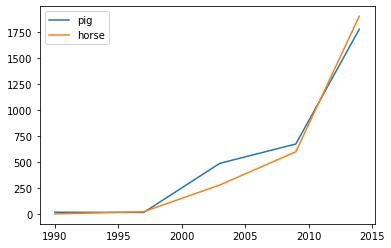

In [2]:
import pandas as pd
df = pd.DataFrame({
    'pig': [20, 18, 489, 675, 1776],
    'horse': [4, 25, 281, 600, 1900]
   }, index=[1990, 1997, 2003, 2009, 2014])
lines = df.plot.line()